In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [14]:
import autoencoder.aecExtraFeatures as Z_calculations

def addZToPrediction(model, data_point):
    reconstruction = model.decoder(model.encoder(data_point))

    Z_features = [Z_calculations.getZVector(data_point, reconstruction)]

    Z_features_tensor = tf.convert_to_tensor(Z_features, dtype=tf.float32)
    data_point = tf.convert_to_tensor(data_point, dtype=tf.float32)

    data_point = tf.concat([data_point, Z_features_tensor], 1)

    return data_point

In [15]:
def isAnomaly(data_point, model_1, model_2, threshold):

    # need autoencoder to return boolean isAnomaly
    isAnomaly = tf.math.less(tf.keras.losses.mae(model_1(data), data), threshold)

    # if the autoencoder doesn't find anything out of the ordinary, return False
    if not isAnomaly:
        return False

    data_point = addZToPrediction(model_1, data_point)

    # if the autoencoder sees something weird, run it through the isolation forest to make sure
    return model_2.predict(data_point)

In [16]:
train_data = pd.read_csv('eda_simple_classification/network_data_mod_train.csv')
test_data = pd.read_csv('eda_simple_classification/network_data_mod_test.csv')

frames = [train_data, test_data]

dataframe  = pd.concat(frames)
raw_data = dataframe.values

In [17]:
# The last element contains the labels
labels = raw_data[:, -1]

data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=34
)

In [18]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [19]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

In [20]:
from autoencoder.autoencoder import AnomalyDetector
autoencoder = AnomalyDetector()

In [21]:
autoencoder.compile(optimizer='adam', loss='mae')

In [22]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=500,
          validation_data=(normal_test_data, normal_test_data),
          shuffle=True)

Epoch 1/500
Tensor("anomaly_detector_1/sequential_2/dense_8/Relu:0", shape=(None, 8), dtype=float32)
Tensor("anomaly_detector_1/sequential_3/dense_11/Sigmoid:0", shape=(None, 47), dtype=float32)
Tensor("anomaly_detector_1/sequential_2/dense_8/Relu:0", shape=(None, 8), dtype=float32)
Tensor("anomaly_detector_1/sequential_3/dense_11/Sigmoid:0", shape=(None, 47), dtype=float32)
1923/1927 [============================>.] - ETA: 0s - loss: 0.0188Tensor("anomaly_detector_1/sequential_2/dense_8/Relu:0", shape=(None, 8), dtype=float32)
Tensor("anomaly_detector_1/sequential_3/dense_11/Sigmoid:0", shape=(None, 47), dtype=float32)
1927/1927 [==============================] - 4s 2ms/step - loss: 0.0187 - val_loss: 3.2629e-04
Epoch 2/500
1927/1927 [==============================] - 3s 1ms/step - loss: 2.7504e-04 - val_loss: 2.3886e-04
Epoch 3/500
1927/1927 [==============================] - 3s 1ms/step - loss: 1.9854e-04 - val_loss: 2.7000e-04
Epoch 4/500
1927/1927 [==============================] 

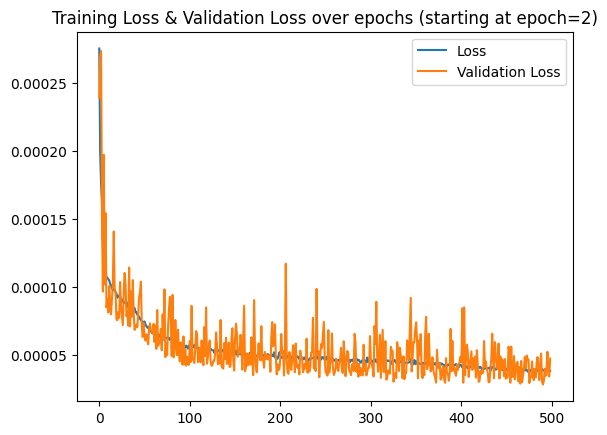

In [51]:
plt.plot(history.history["loss"][1:])
plt.plot(history.history["val_loss"][1:])
plt.title("Training Loss & Validation Loss over epochs (starting at epoch=2)")
plt.legend(["Loss", "Validation Loss"])
plt.show()

In [23]:
reconstructions = autoencoder.predict(train_data)
train_loss = tf.keras.losses.mae(reconstructions, train_data)
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Tensor("anomaly_detector_1/sequential_2/dense_8/Relu:0", shape=(None, 8), dtype=float32)
Tensor("anomaly_detector_1/sequential_3/dense_11/Sigmoid:0", shape=(None, 47), dtype=float32)
3713/3713 [==============================] - 3s 810us/step
Threshold:  0.00010921537


In [24]:
train_data_with_Z = []
for i in range(1, len(train_data)+1):
    train_data_with_Z.append(addZToPrediction(autoencoder, train_data[i-1:i]))

train_data_with_Z_rf = []
for i in range(len(train_data_with_Z)):
    train_data_with_Z_rf.append(train_data[:][:][i].numpy().reshape(1,47).squeeze())

train_data_with_Z_df = pd.DataFrame(train_data_with_Z_rf)

In [26]:
test_data_with_Z = []
for i in range(1, len(test_data)+1):
    test_data_with_Z.append(addZToPrediction(autoencoder, test_data[i-1:i]))

test_data_with_Z_rf = []
for i in range(len(test_data_with_Z)):
    test_data_with_Z_rf.append(test_data[:][:][i].numpy().reshape(1,47).squeeze())

test_data_with_Z_df = pd.DataFrame(test_data_with_Z_rf)

In [29]:
from turtleIsolationForests.extendedIsolationForest import ExtendedIsolationForest

contamination = sum(train_labels == 0) / len(train_labels)

model = ExtendedIsolationForest(contamination = contamination, random_state = None)
model.fit(train_data_with_Z_df, train_labels)

predictions = model.predict(test_data_with_Z_df)
predictions['is_normal'] = test_labels
predictions

In [31]:
from turtleIsolationForests.printResults import print_results

print_results(predictions)

true anomalies: 10935
false anomalies: 3359
false normals: 11955
true normals: 3455
precision: 0.7650062963481181
recall: 0.47771952817824376
f1-score: 0.5881561962134251
